In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats

In [23]:
# File paths
english_mainflow_path = "C:/Users/POOM/Desktop/for export/for export/isitword test - data/yupaen_Mainflow.csv"
thai_mainflow_path = "C:/Users/POOM/Desktop/for export/for export/isitword test - data/yupath_Mainflow.csv"
english_words_path = "C:/Users/POOM/Desktop/for export/for export/isitword test - data/wordorderen_full.xlsx"
thai_words_path = "C:/Users/POOM/Desktop/for export/for export/isitword test - data/wordorderth_full.xlsx"
output_folder = "C:/Users/POOM/Desktop/for export/"
# Load data
english_mainflow = pd.read_csv(english_mainflow_path)
thai_mainflow = pd.read_csv(thai_mainflow_path)
english_words = pd.read_excel(english_words_path)
thai_words = pd.read_excel(thai_words_path)

# SCORE CALCULATION

In [24]:
# Score calculation function
def calculate_score(df):
    conditions = [
        (df['key_resp.keys'] == 'z') & (df['stimuli'] == 1),
        (df['key_resp.keys'] == 'x') & (df['stimuli'].isin([2, 3]))
    ]
    values = [1, 1]
    df['score'] = np.select(conditions, values, default=0)
    return df

def cutdf(prepdf):
    cutdf = prepdf.iloc[1:121][["lang","imageid","stimuli","key_resp.keys","key_resp.rt"]].reset_index(drop=True)
    return cutdf

# Apply score calculation
english_mainflow = calculate_score(cutdf(english_mainflow))
thai_mainflow = calculate_score(cutdf(thai_mainflow))

# WORD LENGTH

In [25]:
# Word length calculation function
def get_word_length(df, words_df, lang):
    word_length_dict = words_df.set_index('imageid')['word shown'].astype(str).apply(len).to_dict()
    df['word_length'] = df['imageid'].map(word_length_dict)
    return df

english_mainflow = get_word_length(english_mainflow, english_words, 'English')
thai_mainflow = get_word_length(thai_mainflow, thai_words, 'Thai')

# CHANGE STIMULI

In [26]:
def convert_stimuli(df):
    stimuli_map = {1: 'Correct', 2: 'Scramble', 3: 'Typo'}
    df['stimuli'] = df['stimuli'].map(stimuli_map)
    return df

# Apply Stimuli Conversion
english_mainflow = convert_stimuli(english_mainflow)
thai_mainflow = convert_stimuli(thai_mainflow)

In [22]:
# Combine data for analysis
english_mainflow['Language'] = 'English'
thai_mainflow['Language'] = 'Thai'
data = pd.concat([english_mainflow, thai_mainflow])

# Create output directory if not exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to plot graphs
def save_plot(fig, title):
    file_path = os.path.join(output_folder, title + ".png")
    fig.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

# Remove Pear Hose Drill Couch

In [15]:
# List of words to exclude
exclude_words = ["pear", "hose", "drill", "couch"]

# Filter English mainflow dataset
english_mainflow = english_mainflow[~english_mainflow['imageid'].isin(english_words[english_words['word shown'].isin(exclude_words)]['imageid'])]

Calculate React time

In [16]:
# Reaction time analysis
reaction_time_means = data.groupby('Language')['key_resp.rt'].mean()
reaction_time_sems = data.groupby('Language')['key_resp.rt'].sem()

# ALL CODES BELOW GENERATE GRAPH

%correct vs lang

In [17]:
# Plot percentage correct per language
correct_rates = data.groupby('Language')['score'].mean() * 100
fig, ax = plt.subplots()
correct_rates.plot(kind='bar', color=['red', 'blue'], ax=ax)
ax.set_ylabel("% Correct")
ax.set_title("%Correct by Language")
ax.set_xticklabels(reaction_time_means.index, rotation=0)
for container in ax.containers:
    if hasattr(container, 'patches'):
        ax.bar_label(container)
plt.ylim(0,110)
save_plot(fig, "percentage_correct_by_language")

%correct vs length

In [18]:
# Word length vs % correct
fig, ax = plt.subplots()
data['score'] = data['score'] * 100

# Plot bar chart
plot = sns.barplot(x='word_length', y='score', hue='Language', data=data, ax=ax, errorbar=None, palette=['red', 'blue'])

# Remove "Language" from legend
ax.legend(title="")

# Add labels above bars
for p in plot.patches:
    height = p.get_height()
    if height > 0:
        label = f'{int(height)}' if height.is_integer() else f'{height:.1f}'
        ax.text(p.get_x() + p.get_width() / 2, height, f'{height:.1f}', ha='center', va='bottom', )

# Labels and title
ax.set_ylabel("% Correct")
ax.set_xlabel("Word Length")
ax.set_title("Percentage Correct by Word Length")

ax.legend(loc='upper right', bbox_to_anchor=(1, 0.2))
ax.set_ylim(0, 110)

# Save plot
save_plot(fig, "percentage_correct_by_word_length")

# Restore original score values
data['score'] = data['score'] / 100

%correct vs stimuli

In [19]:
# Stimuli vs % correct
fig, ax = plt.subplots()
data['score'] = data['score'] * 100
sns.barplot(x='stimuli', y='score', hue='Language', data=data, ax=ax, errorbar=None, palette=['red', 'blue'])

# Add labels above bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        label = f'{int(height)}' if height.is_integer() else f'{height:.1f}'
        ax.text(p.get_x() + p.get_width() / 2, height, label, ha='center', va='bottom')

# Labels and title
ax.set_ylabel("% Correct")
ax.set_xlabel("Stimuli Type")
ax.set_title("Percentage Correct by Stimuli Type")

# Adjust legend position
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.2))

# Set y-axis limits
ax.set_ylim(0, 110)

# Save plot
save_plot(fig, "percentage_correct_by_stimuli")

# Restore original score values
data['score'] = data['score'] / 100

# Reactime vs lang

In [20]:
fig, ax = plt.subplots()
reaction_time_means.plot(kind='bar', yerr=reaction_time_sems, capsize=5, color=['red', 'blue'], ax=ax)
ax.set_ylabel("Reaction Time (s)")
ax.set_title("Reaction Time by Language")
ax.set_xticklabels(reaction_time_means.index, rotation=0)
for container in ax.containers:
    if hasattr(container, 'patches'):
        ax.bar_label(container)
save_plot(fig, "reaction_time_by_language")

Freedman-Diaconis Rule AND Create BOX plot AND Histogram

In [21]:
def freedman_diaconis_bins(data):
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    bin_width = 2 * iqr * (len(data) ** (-1/3))
    return max(1, int((data.max() - data.min()) / bin_width))

In [22]:
def plot_histogram_with_boxplot(data, x_label, title, filename, color):
    bins = freedman_diaconis_bins(data)
    fig, ax = plt.subplots()
    sns.histplot(data, bins=bins, kde=False, color=color, ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    plt.ylim(0, 110)
    plt.boxplot(data, vert=False, widths=0.7, positions=[ax.get_ylim()[1] - 5], patch_artist=True, boxprops=dict(facecolor='white', color='black'))
    save_plot(fig, filename)

In [23]:
# Function to Plot Histogram with Boxplot
def plot_histogram_with_boxplot(data, x_label, title, filename, color):
    bins = freedman_diaconis_bins(data)
    fig, (ax_box, ax_hist) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(8, 6), sharex=True)
    
    # Boxplot
    sns.boxplot(x=data, ax=ax_box, color=color, boxprops=dict(facecolor="lightblue"))
    ax_box.set(xlabel='')
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    
    # Histogram
    sns.histplot(data, bins=bins, kde=False, color=color, ax=ax_hist)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title(title)
    
    plt.tight_layout()
    save_plot(fig, filename)


Language VS Reaction Time Histogram

In [24]:
for lang in ['All', 'English', 'Thai']:
    df = data if lang == 'All' else data[data['Language'] == lang]
    if not df.empty:
        plot_histogram_with_boxplot(df['key_resp.rt'], "Reaction Time (ms)", f"Reaction time: {lang} word", f"reaction_time_{lang.lower()}", 'grey' if lang == 'All' else 'red' if lang == 'English' else 'blue')

# Word Length vs Reaction Time Graphs

In [25]:
'''
for lang in ['All', 'English', 'Thai']:
    df = data if lang == 'All' else data[data['Language'] == lang]
    if not df.empty:
        plot_histogram_with_boxplot(df['word_length'], "Word Length", f"Reaction Time by Word Length ({lang})", f"reaction_time_by_word_length_{lang.lower()}", 'grey' if lang == 'All' else 'red' if lang == 'English' else 'blue')
'''

'\nfor lang in [\'All\', \'English\', \'Thai\']:\n    df = data if lang == \'All\' else data[data[\'Language\'] == lang]\n    if not df.empty:\n        plot_histogram_with_boxplot(df[\'word_length\'], "Word Length", f"Reaction Time by Word Length ({lang})", f"reaction_time_by_word_length_{lang.lower()}", \'grey\' if lang == \'All\' else \'red\' if lang == \'English\' else \'blue\')\n'

In [26]:
'''
reaction_time_means = data.groupby('word_length')['key_resp.rt'].mean()
reaction_time_sems = data.groupby('word_length')['key_resp.rt'].sem()
fig, ax = plt.subplots()
reaction_time_means.plot(kind='bar', yerr=reaction_time_sems, capsize=5, color='grey', ax=ax)
ax.set_ylabel("Reaction Time (s)")
ax.set_xlabel("Word Length")
ax.set_title("Reaction Time by Word Length")
for container in ax.containers:
    if hasattr(container, 'patches'):
        ax.bar_label(container)
save_plot(fig, "reaction_time_by_word_length")
'''

'\nreaction_time_means = data.groupby(\'word_length\')[\'key_resp.rt\'].mean()\nreaction_time_sems = data.groupby(\'word_length\')[\'key_resp.rt\'].sem()\nfig, ax = plt.subplots()\nreaction_time_means.plot(kind=\'bar\', yerr=reaction_time_sems, capsize=5, color=\'grey\', ax=ax)\nax.set_ylabel("Reaction Time (s)")\nax.set_xlabel("Word Length")\nax.set_title("Reaction Time by Word Length")\nfor container in ax.containers:\n    if hasattr(container, \'patches\'):\n        ax.bar_label(container)\nsave_plot(fig, "reaction_time_by_word_length")\n'

AttributeError: 'Axes' object has no attribute 'datavalues'

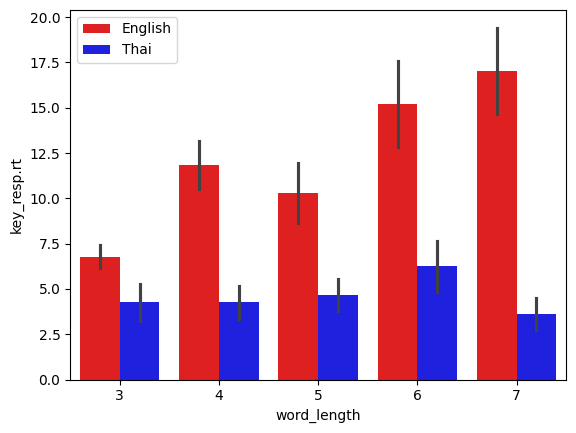

In [27]:
fig, ax = plt.subplots()
plot = sns.barplot(x='word_length', y='key_resp.rt', hue='Language', data=data, ax=ax, errorbar='se', palette=['red', 'blue'])
ax.legend(title="")
'''
for p in plot.patches:
    height = p.get_height()
    errorbar = p.get_errorbar()
    if height > 0:
        label = f'{int(height)}' if height.is_integer() else f'{height:.1f}'
        ax.text(p.get_x() + p.get_width() / 2, 1, label, ha='center', va='top', fontsize=10, color='white')
'''
for p, (_, error) in zip(plot.patches, plot.datavalues):
    height = p.get_height()
    if height > 0:
        label = f'{int(height)}' if height.is_integer() else f'{height:.1f}'
        ax.text(p.get_x() + p.get_width() / 2, height + error + 0.1, label, 
                ha='center', va='bottom', fontsize=10, color='black')
'''
ax.bar_label(ax.containers[0], fmt='%.1f', label_type='edge', padding=3, fontsize=10)
ax.bar_label(ax.containers[1], fmt='%.1f', label_type='edge', padding=3, fontsize=10)
'''
ax.set_ylabel("Reaction Time (s)")
ax.set_ylabel("Reaction Time (s)")
ax.set_xlabel("Word Length")
ax.set_title("Reaction Time by Word Length")
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax.set_ylim(0, 20)
save_plot(fig, "reaction_time_by_word_length")

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots()

# Create the barplot
plot = sns.barplot(x='word_length', y='key_resp.rt', hue='Language', data=data, ax=ax, errorbar='se', palette=['red', 'blue'])

# Compute standard error manually
se_values = data.groupby(['word_length', 'Language'])['key_resp.rt'].sem().reset_index()
se_dict = {(row['word_length'], row['Language']): row['key_resp.rt'] for _, row in se_values.iterrows()}

# Remove legend title
ax.legend(title="")

# Manually place labels at height + SE + padding
for container in plot.containers:
    for bar in container:
        height = bar.get_height()
        word_length = int(round(bar.get_x() + bar.get_width() / 2))  # Approximate x position
        language = bar.get_label()  # Get hue category (may be empty)

        # Retrieve standard error if available, else default to 0
        error = se_dict.get((word_length, language), 0)

        # Debugging print statements (check values)
        print(f"Word Length: {word_length}, Language: {language}, Height: {height}, SE: {error}")

        if height > 0:
            label = f'{int(height)}' if height.is_integer() else f'{height:.1f}'
            ax.text(bar.get_x() + bar.get_width() / 2, height + error + 0.1, label,
                    ha='center', va='bottom', fontsize=10, color='black', weight='bold')

# Adjust labels, title, and limits
ax.set_ylabel("Reaction Time (s)")
ax.set_xlabel("Word Length")
ax.set_title("Reaction Time by Word Length")
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax.set_ylim(0, 20)

# Save the plot
save_plot(fig, "reaction_time_by_word_length")


Word Length: 0, Language: _nolegend_, Height: 6.776302850875001, SE: 0
Word Length: 1, Language: _nolegend_, Height: 11.828855265869567, SE: 0
Word Length: 2, Language: _nolegend_, Height: 10.277006141958333, SE: 0
Word Length: 3, Language: _nolegend_, Height: 15.183142946958334, SE: 0
Word Length: 4, Language: _nolegend_, Height: 17.039694884291666, SE: 0
Word Length: 0, Language: _nolegend_, Height: 4.256322426999986, SE: 0
Word Length: 1, Language: _nolegend_, Height: 4.257361977150003, SE: 0
Word Length: 2, Language: _nolegend_, Height: 4.657769012636339, SE: 0
Word Length: 3, Language: _nolegend_, Height: 6.2411631805417755, SE: 0
Word Length: 4, Language: _nolegend_, Height: 3.5922710263666278, SE: 0


# Stimuli Type vs Reaction Time Graphs

In [ ]:
'''
for lang in ['All', 'English', 'Thai']:
    df = data if lang == 'All' else data[data['Language'] == lang]
    if not df.empty:
        plot_histogram_with_boxplot(df['key_resp.rt'], "Reaction Time (ms)", f"Reaction Time by Stimuli Type ({lang})", f"reaction_time_by_stimuli_{lang.lower()}", 'grey' if lang == 'All' else 'red' if lang == 'English' else 'blue')
'''

'\nfor lang in [\'All\', \'English\', \'Thai\']:\n    df = data if lang == \'All\' else data[data[\'Language\'] == lang]\n    if not df.empty:\n        plot_histogram_with_boxplot(df[\'key_resp.rt\'], "Reaction Time (ms)", f"Reaction Time by Stimuli Type ({lang})", f"reaction_time_by_stimuli_{lang.lower()}", \'grey\' if lang == \'All\' else \'red\' if lang == \'English\' else \'blue\')\n'

In [ ]:
'''
reaction_time_means = data.groupby('stimuli')['key_resp.rt'].mean()
reaction_time_sems = data.groupby('stimuli')['key_resp.rt'].sem()
fig, ax = plt.subplots()
reaction_time_means.plot(kind='bar', yerr=reaction_time_sems, capsize=5, color='grey', ax=ax)
ax.set_ylabel("Reaction Time (s)")
ax.set_xlabel("Stimuli Type")
ax.set_title("Reaction Time by Stimuli Type")
for container in ax.containers:
    if hasattr(container, 'patches'):
        ax.bar_label(container)
save_plot(fig, "reaction_time_by_stimuli")
'''

'\nreaction_time_means = data.groupby(\'stimuli\')[\'key_resp.rt\'].mean()\nreaction_time_sems = data.groupby(\'stimuli\')[\'key_resp.rt\'].sem()\nfig, ax = plt.subplots()\nreaction_time_means.plot(kind=\'bar\', yerr=reaction_time_sems, capsize=5, color=\'grey\', ax=ax)\nax.set_ylabel("Reaction Time (s)")\nax.set_xlabel("Stimuli Type")\nax.set_title("Reaction Time by Stimuli Type")\nfor container in ax.containers:\n    if hasattr(container, \'patches\'):\n        ax.bar_label(container)\nsave_plot(fig, "reaction_time_by_stimuli")\n'

In [ ]:
fig, ax = plt.subplots()
plot = sns.barplot(x='stimuli', y='key_resp.rt', hue='Language', data=data, ax=ax, errorbar='se', palette=['red', 'blue'])
ax.legend(title="")
for p in plot.patches:
    height = p.get_height()
    if height > 0:
        label = f'{int(height)}' if height.is_integer() else f'{height:.1f}'
        ax.text(p.get_x() + p.get_width() / 2, 1, label, ha='center', va='top', fontsize=10, color='white')
ax.set_ylabel("Reaction Time (s)")
ax.set_xlabel("Stimuli Type")
ax.set_title("Reaction Time by Stimuli Type")
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax.set_ylim(0, 20)
save_plot(fig, "reaction_time_by_stimuli")